Found 2004 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(20, 150, 150, 3)
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.]
(20,)
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.]


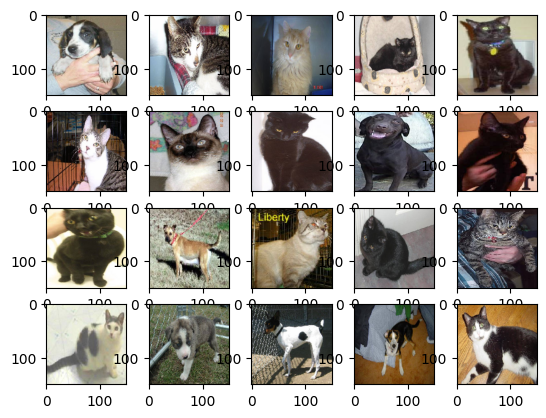

In [5]:
#ImageDataGenerator 이용
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#path
train_dir = './cat_dog_small/train'
validation_dir = './cat_dog_small/validation'

#생성
train_datagen = ImageDataGenerator(rescale = 1/255)  # 0 ~ 1까지 정규화
validation_datagen = ImageDataGenerator(rescale = 1/255)

#설정
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes = ['cats', 'dogs'],  #타켓, 레이블
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes = ['cats', 'dogs'],  #타켓, 레이블
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

# generator 동작확인

# 한번에 20개 이미지 가져와서 띄우기
fig = plt.figure()
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4, 5, i+1))

for data_batch, label_batch in train_generator:
    print(data_batch.shape)
    print(label_batch)

    for idx, img_data in enumerate(data_batch):
        axs[idx].imshow(img_data)
    
    print(label_batch.shape)
    print(label_batch)
    break


In [6]:
from tensorflow.keras.applications import VGG16

model_base = VGG16(
    weights = 'imagenet',
    include_top = False, # filter만 가져옴
    input_shape = (150, 150, 3)
)

model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
# VGG16 -> 전이학습
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1.모델생성
model = Sequential()

# 2.VGG16으로 대체 
model_base = VGG16(
    weights = 'imagenet',
    include_top = False, # filter만 가져옴
    input_shape = (150, 150, 3)
)

# 3.특성 추출
model_base.trainable = False # 이미 완성된 필터만 사용, 변경하지 않을것

model.add(model_base)

model.add(Flatten())

model.add(Dense(
    units = 1,
    activation = 'sigmoid'
))
model.summary()

# 모델 설정
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

# 학습
model.fit(
    train_generator,
    steps_per_epoch = 100,  #2000 / 20 = 100
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = 50,  #1000 / 20 = 50
    verbose = 1
)
model.save('./my_model')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 14722881 (56.16 MB)
Trainable params: 8193 (32.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/5
100/100 [==============================] - 129s 1s/step - loss: 0.5842 - acc: 0.7036 - val_loss: 0.5114 - val_acc: 0.7930
Epoch 2/5
100/100 [==============================] - 142s 1s/step - loss: 0.4495 - acc: 0.8246 - val_loss: 0.4303 - val_acc: 0.8250
Epoch 3/5


INFO:tensorflow:Assets written to: ./my_model\assets
